In [145]:
import cv2
import os
from datetime import datetime
import time
import csv
import numpy as np
import onnxruntime as ort
from ultralytics import YOLO
from ultralytics.utils import LOGGER
import joblib
import torch
from facenet_pytorch import InceptionResnetV1, MTCNN
from torchvision import transforms
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.exposure import match_histograms

LOGGER.setLevel(50)

### Load model 

In [146]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mtcnn = MTCNN(keep_all=True, device=device)
facenet = InceptionResnetV1(pretrained="vggface2").eval().to(device)
classifier = joblib.load("models/face_classifier.pkl")
label_encoder = joblib.load("models/label_encoder.pkl")

In [147]:
yolo_model = YOLO("models/yolov8n.pt")
session = ort.InferenceSession("models/public/anti-spoof-mn3/anti-spoof-mn3.onnx")

### Load image test

(-0.5, 2315.5, 3087.5, -0.5)

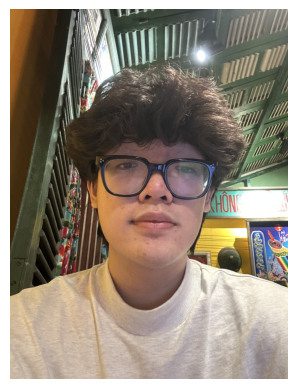

In [148]:
img_path = r'dataset\students\HE190303\IMG_5870.JPG'

img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


plt.imshow(img_rgb)
plt.axis('off')

## YOLOv8n

In [150]:
phone_detected = False
results = yolo_model(img_rgb)

for result in results:
    for box in result.boxes:
        cls_id = int(box.cls[0].item())  # Get class ID
        if cls_id == 67:  # Class ID 67 = "Cell Phone" in COCO dataset
            phone_detected = True
phone_detected

False

## anti-spoof-mn3

In [151]:
def frame_processing(img, to_rgb=True):
    if to_rgb:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    img = np.transpose(img, (2, 0, 1)).astype(np.float32)/255.0
    img = np.expand_dims(img, axis = 0)
    return img

img shape : (1, 3, 128, 128)


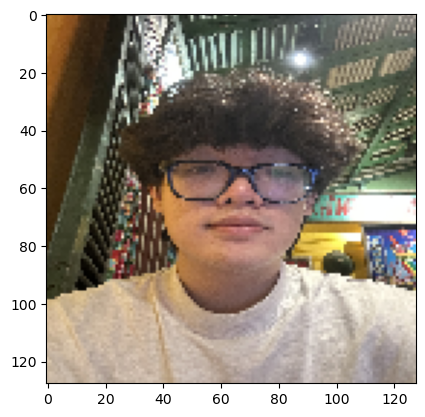

In [152]:
img_ = frame_processing(img)
print("img shape :", img_.shape)
img_t = img_.squeeze(0)  # Bỏ chiều batch -> (3, 128, 128)

# Chuyển từ (C, H, W) -> (H, W, C)
img_t = img_t.transpose(1, 2, 0)

# Hiển thị ảnh
plt.imshow(img_t)
plt.show()

In [154]:
session.get_inputs()

In [155]:
input_name = session.get_inputs()[0].name
input_name

'actual_input_1'

In [156]:
output = session.run(None, {input_name: img_})[0]  # Run inference
output

array([[    0.89061,     0.10939]], dtype=float32)

In [157]:
conf = output[0][0]
conf

0.89061326

## MTCNN 

In [158]:
boxes, _ = mtcnn.detect(img_rgb)
print(boxes)
print(_)


[[722.6181640625 931.9968872070312 1674.5087890625 2106.677490234375]]
[0.9999412298202515]


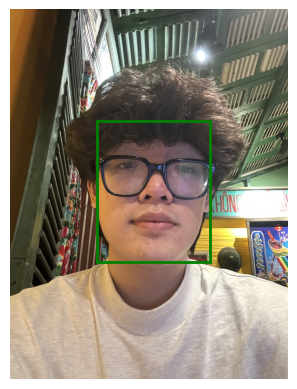

In [159]:
fig, ax = plt.subplots()
ax.imshow(img_rgb, cmap="gray")

# Vẽ hình chữ nhật (x, y, width, height)
rect = patches.Rectangle((boxes[0][0], boxes[0][1]), boxes[0][2] - boxes[0][0], boxes[0][3] - boxes[0][1], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(rect)
plt.axis('off')
plt.show()

There is/are 1 in the images
(1175, 952, 3)


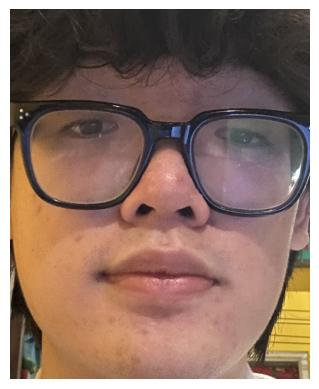

In [160]:
faces = []

for box in boxes:
    x1, y1, x2, y2 = map(int, box)
    face = img_rgb[y1:y2, x1:x2]
    faces.append(face)
print(f"There is/are {len(faces)} in the images")

for face in faces:
    print(face.shape)
    plt.imshow(face)
    plt.axis('off')
    plt.show()

## FaceNet Classification

In [161]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [162]:
face_tensor = transform(face).unsqueeze(0).to(device)
with torch.no_grad():
    embedding = facenet(face_tensor).cpu().numpy().flatten().reshape(1, -1)
    
print(embedding)

[[   0.042309 -0.00041267   -0.044895    0.038391    -0.01083    0.039548   -0.051279    0.029384   -0.032032    0.021695    0.034475     0.08948    0.023214   -0.029714   -0.033671    0.014941    0.083412     0.10276  -0.0065951    0.043931   0.0052257     0.02281    0.037096   -0.051998    0.013957   -0.012146
    -0.011231    0.051859    0.046184    0.026505    0.020234   -0.047301   -0.032661   -0.015549    0.020037  -0.0074343   -0.045852    -0.11392   0.0061523    0.053241   0.0022482    0.025633    0.026924   -0.036311   -0.033551     0.06733   -0.028058   0.0096962    -0.01381  -0.0037332   -0.013834   -0.051325
     0.044728  0.00083253   -0.032399   -0.025931   -0.021824    0.043155   -0.021029    0.011729    0.012077      0.1443   -0.054765     0.07528   -0.025784   0.0021983   0.0060655   -0.035719    0.026012  -0.0063102    0.014659    0.053473   -0.020148    0.013583    0.012614   -0.065766   -0.065097    0.024061
     0.011802   -0.051917   0.0087799   -0.068948   -0.057

In [163]:
pred_label = classifier.predict(embedding)
pred_label

array([3], dtype=int64)

In [164]:
pred_student = label_encoder.inverse_transform(pred_label)[0]
pred_student

'HE190303'